# Programming Exercise 2: Logistic Regression

## Introduction

In this exercise, you will implement logistic regression and apply it to two different datasets. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. The assignment can be promptly submitted to the coursera grader directly from this notebook (code and instructions are included below).

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, and [`matplotlib`](https://matplotlib.org/) for plotting. In this assignment, we will also use [`scipy`](https://docs.scipy.org/doc/scipy/reference/), which contains scientific and numerical computation functions and tools. 

## 1 Logistic Regression

In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university. Suppose that you are the administrator of a university department and
you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions
decision. Your task is to build a classification model that estimates an applicant’s probability of admission based the scores from those two exams. 

The following cell will load the data and corresponding labels:

In [1]:
import pandas as pd
import numpy as np

In [2]:
students = pd.read_csv("ex2data1.txt", names=["First_Exam", "Second_Exam", "Admission_Status"])
# type casting from pandas series and pandas dataframe to numpy array
X = np.array(students[["First_Exam", "Second_Exam"]])
y = np.array(students["Admission_Status"])
# size of dataset
number_of_samples = y.size
# size of X matrix, m= rows, n= features
m,n = X.shape
print('size of samples: {}'.format(number_of_samples))

size of samples: 100


In [3]:
students.head()

,First_Exam,Second_Exam,Admission_Status
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


### 1.1 Visualizing the data

Before starting to implement any learning algorithm, it is always good to visualize the data if possible.

In [4]:
import matplotlib.pyplot as plt

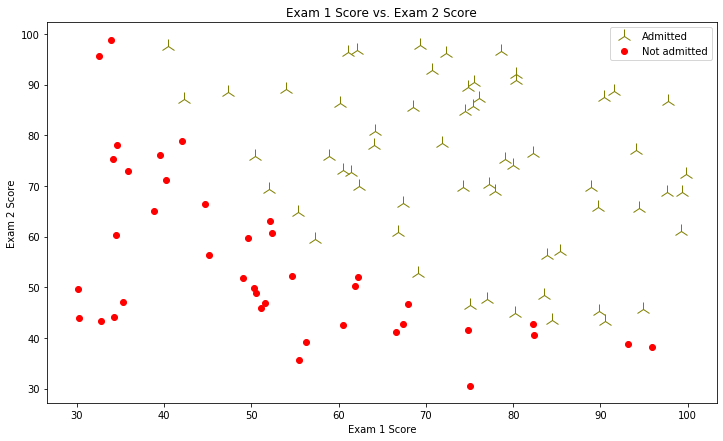

In [5]:
plt.figure(figsize= (12,7))
plt.plot(X[:,0][y == 1], X[:,1][y == 1], "2", ms=15, c= "olive")
plt.plot(X[:,0][y == 0], X[:,1][y == 0], ".", ms=12, c= "red")
plt.legend(["Admitted", "Not admitted"])
plt.xlabel("Exam 1 Score")
plt.ylabel("Exam 2 Score")
plt.title("Exam 1 Score vs. Exam 2 Score")
plt.show()

### 1.2 Implementation

#### 1.2.1 Warmup exercise: sigmoid function

Before you start with the actual cost function, recall that the logistic regression hypothesis is defined as:

$$ h_\theta(x) = g(\theta^T x)$$

where function $g$ is the sigmoid function. The sigmoid function is defined as: 

$$g(z) = \frac{1}{1+e^{-z}}$$.

Your first step is to implement this function `sigmoid` so it can be
called by the rest of your program. When you are finished, try testing a few
values by calling `sigmoid(x)` in a new cell. For large positive values of `x`, the sigmoid should be close to 1, while for large negative values, the sigmoid should be close to 0. Evaluating `sigmoid(0)` should give you exactly 0.5. Your code should also work with vectors and matrices. **For a matrix, your function should perform the sigmoid function on every element.**


In [6]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.
    
    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector 
        or a 2-D matrix. 
    
    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.
        
    Instructions
    ------------
    Compute the sigmoid of each value of z (z can be a matrix, vector or scalar).
    """
    # convert every element to numpy array (matrix, vector or scalar)
    z = np.array(z)
    # create free space as size as input 
    g = np.zeros(z.shape)
    # computing sigmoid function
    g = (1 / (1 + np.exp(-z)))
    
    return g

In [7]:
# test sigmoid function
z = 0
g = sigmoid(z)

print("Actual value of sigmoid(0) should be 0.5")
print("Computed value of sigmoid(0) is {sigmoid}".format(sigmoid= g))

Actual value of sigmoid(0) should be 0.5
Computed value of sigmoid(0) is 0.5


#### 1.2.2 Cost function and gradient

Now you will implement the cost function and gradient for logistic regression. Before proceeding we add the intercept term to X. 

In [8]:
# add intercept term to martix X
X = np.concatenate([np.ones((len(X), 1)), X], axis= 1)

Now, complete the code for the function `cost_function` to return the cost value and define `gradient_descent` to reteun gradient. Recall that the cost function in logistic regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

and the gradient of the cost is a vector of the same length as $\theta$ where the $j^{th}$
element (for $j = 0, 1, \cdots , n$) is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Note that while this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $h_\theta(x)$.

In [9]:
def cost_function(theta, X, y):
    """
    Compute cost_function for logistic regression. 
    
    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).
    
    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the 
        intercept has already been added to the input.
    
    y : arra_like
        Labels for the input. This is a vector of shape (m, ).
    
    Returns
    -------
    J : float
        The computed value for the cost function. 
    
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to 
    the cost. Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values like number_of_samples, J and grad
    number_of_samples = y.size
    J = 0
    grad = np.zeros(theta.shape)
    # hypothesis function
    h = sigmoid(np.dot(X, theta.T))
    # implementation of J
    J = (1/number_of_samples) * (np.sum(np.dot(-y, np.log(h))) - np.dot((1-y), (np.log(1-h))))
    
    return J

In [10]:
def gradient_descent(theta, X, y):
    """
    Compute gradient_descent for logistic regression. 
    
    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).
    
    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the 
        intercept has already been added to the input.
    
    y : arra_like
        Labels for the input. This is a vector of shape (m, ).
    
    Returns
    -------
    grad : array_like
        A vector of shape (n+1, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
        
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to 
    the cost. Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values like number_of_samples, J and grad
    grad = np.zeros(theta.shape)
    # hypothesis function
    h = sigmoid(np.dot(X, theta.T))
    # implementation of gradient
    grad = (1/number_of_samples) * np.dot((h - y), X)
    
    return grad

In [11]:
initial_theta = np.zeros(n+1)
grad = gradient_descent(initial_theta, X, y)
cost = cost_function(initial_theta,X,y)
print("Shape of cost value is: {}".format(cost))
print("Shape of grad is: {}".format(grad.shape))

Shape of cost value is: 0.6931471805599452
Shape of grad is: (3,)


In [12]:
# test multiple theta and check with actual values
initial_theta = np.zeros(n+1)
grad = gradient_descent(initial_theta, X, y)
cost = cost_function(initial_theta,X,y)
print("Cost at initial theta (zeros): {:.3f}".format(cost))
print("Expected cost (approx): 0.693\n")

print("Gradient at initial theta (zeros):")
print("\t[{:.4f}, {:.4f}, {:.4f}]".format(*grad))
print("Expected gradients (approx):\n\t[-0.1000, -12.0092, -11.2628]\n")

# Compute and display cost and gradient with non-zero theta
test_theta = np.array([-24, 0.2, 0.2])
cost = cost_function(test_theta, X, y)
grad = gradient_descent(test_theta, X, y)

print("Cost at test theta: {:.3f}".format(cost))
print("Expected cost (approx): 0.218\n")

print("Gradient at test theta:")
print("\t[{:.3f}, {:.3f}, {:.3f}]".format(*grad))
print("Expected gradients (approx):\n\t[0.043, 2.566, 2.647]")

Cost at initial theta (zeros): 0.693
Expected cost (approx): 0.693

Gradient at initial theta (zeros):
	[-0.1000, -12.0092, -11.2628]
Expected gradients (approx):
	[-0.1000, -12.0092, -11.2628]

Cost at test theta: 0.218
Expected cost (approx): 0.218

Gradient at test theta:
	[0.043, 2.566, 2.647]
Expected gradients (approx):
	[0.043, 2.566, 2.647]


#### 1.2.3 Learning parameters using `scipy.optimize`

In the previous assignment, you found the optimal parameters of a linear regression model by implementing gradient descent. You wrote a cost function and calculated its gradient, then took a gradient descent step accordingly. This time, instead of taking gradient descent steps, you will use the [`scipy.optimize` module](https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy is a numerical computing library for `python`. It provides an optimization module for root finding and minimization. As of `scipy 1.0`, the function `scipy.optimize.minimize` is the method to use for optimization problems(both constrained and unconstrained).

For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.
Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of X and y values). You will pass to `optimize.minimize` the following inputs:
- `cost_function`: A cost function that, when given the training set and a particular $\theta$, computes the logistic regression cost and gradient with respect to $\theta$ for the dataset (X, y). It is important to note that we only pass the name of the function without the parenthesis. This indicates that we are only providing a reference to this function, and not evaluating the result from this function.
- `initial_theta`: The initial values of the parameters we are trying to optimize.
- `(X, y)`: These are additional arguments to the cost function.
- `jac`: Indication if the cost function returns the Jacobian (gradient) along with cost value. (True)
- `method`: Optimization method/algorithm to use
- `options`: Additional options which might be specific to the specific optimization method. In the following, we only tell the algorithm the maximum number of iterations before it terminates.

If you have completed the `cost_function` correctly, `optimize.minimize` will converge on the right optimization parameters and return the final values of the cost and $\theta$ in a class object. Notice that by using `optimize.minimize`, you did not have to write any loops yourself, or set a learning rate like you did for gradient descent. This is all done by `optimize.minimize`: you only needed to provide a function calculating the cost and the gradient.

In the following, we already have code written to call `optimize.minimize` with the correct arguments.

In [13]:
from scipy import optimize

In [14]:
# define initial values
options= {"maxiter": 400, "disp": True}
initial_theta = np.zeros(n+1)
# optimize cost_function with method= "TNC". for more information check below link
# https://docs.scipy.org/doc/scipy/reference/optimize.minimize-tnc.html#optimize-minimize-tnc
# if you define cost_function and gradient_descent in one function, then you need to change below options as below
# the unified function that contains cost and grad will not need to pass another function on
# jac= on optimize.minimize function and only True value is enough, but when we have separate functions
# cost_function is out main function and jac= gradient_descent work same as past
result= optimize.minimize(cost_function, initial_theta, (X, y), jac= gradient_descent, method= "TNC", options= options)
# put optimizied values in variables
# fun property is minimum value and x is optimized theta
cost_value= result.fun
theta_optimized= result.x

In [15]:
result

     fun: 0.2034977015894746
     jac: array([8.96939697e-09, 8.36911572e-08, 4.76674440e-07])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 36
     nit: 17
  status: 0
 success: True
       x: array([-25.16131863,   0.20623159,   0.20147149])

In [16]:
print("Optimized theta is: {}".format(theta_optimized))
print("Optimized Cost value is: {:.4f}".format(cost_value))

Optimized theta is: [-25.16131863   0.20623159   0.20147149]
Optimized Cost value is: 0.2035


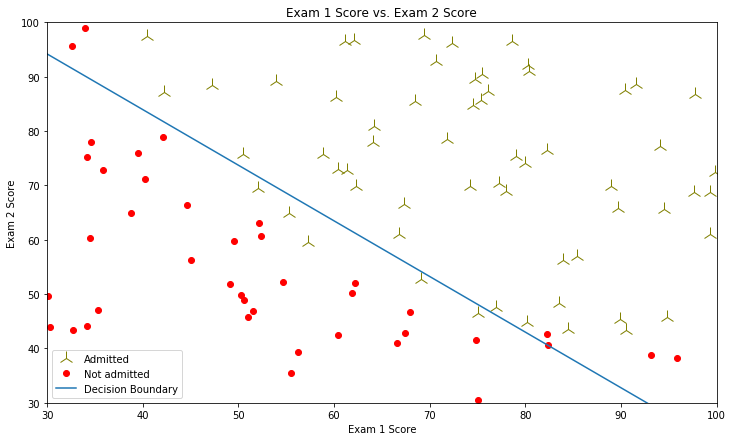

In [17]:
plt.figure(figsize= (12,7))
plt.plot(X[:,1][y == 1], X[:,2][y == 1], "2", ms=15, c= "olive")
plt.plot(X[:,1][y == 0], X[:,2][y == 0], ".", ms=12, c= "red")
plt.xlabel("Exam 1 Score")
plt.ylabel("Exam 2 Score")
plt.title("Exam 1 Score vs. Exam 2 Score")

plot_x = np.array([np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2])

# Calculate the decision boundary line
plot_y = (-1. / theta_optimized[2]) * (theta_optimized[1] * plot_x + theta_optimized[0])

# Plot, and adjust axes for better viewing
plt.plot(plot_x, plot_y)

# Legend, specific for the exercise
plt.legend(['Admitted', 'Not admitted', 'Decision Boundary'])
plt.xlim([30, 100])
plt.ylim([30, 100])
plt.show()

#### 1.2.4 Evaluating logistic regression

After learning the parameters, you can use the model to predict whether a particular student will be admitted. For a student with an Exam 1 score of 45 and an Exam 2 score of 85, you should expect to see an admission
probability of 0.776. Another way to evaluate the quality of the parameters we have found is to see how well the learned model predicts on our training set. In this part, your task is to complete the code in function `predict`. The predict function will produce “1” or “0” predictions given a dataset and a learned parameter vector $\theta$.

In [18]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5 
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)
    
    Parameters
    ----------
    theta : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).
    
    X : array_like
        The data to use for computing predictions. The rows is the number 
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X. 
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned 
    logistic regression parameters.You should set p to a vector of 0's and 1's    
    """
    number_of_samples= X.shape[0] # number of exmaple 
    predicted= np.zeros(number_of_samples)
    
    predicted = np.round(sigmoid(np.dot(X, theta.T))) # round using a threshold at 0.5
    return predicted

After you have completed the code in `predict`, we proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct.

In [19]:
# Predict probability for a student with score 45 on exam 1 
# and score 85 on exam 2 
prob = sigmoid(np.dot([1, 45, 85], theta_optimized))
print("For a student with scores 45 and 85,we predict an admission probability of {:.3f}".format(prob))
print("Expected value: 0.775 +/- 0.002\n")
# Compute accuracy on our training set
model_predicted = predict(theta_optimized, X)
print("Train Accuracy(Numpy Equal Checking): {:.2f} %".format(np.mean(model_predicted == y) * 100))
print("Expected accuracy (approx): 89.00 %\n")
# Compute accuracy with XNOR logic
model_predicted = predict(theta_optimized, X)
print("Train Accuracy(XNOR Logic): {:.2f} %".format(np.mean(np.invert(np.logical_xor(model_predicted, y))) * 100))
print("Expected accuracy (approx): 89.00 %")

For a student with scores 45 and 85,we predict an admission probability of 0.776
Expected value: 0.775 +/- 0.002

Train Accuracy(Numpy Equal Checking): 89.00 %
Expected accuracy (approx): 89.00 %

Train Accuracy(XNOR Logic): 89.00 %
Expected accuracy (approx): 89.00 %


## 2 Regularized logistic regression

In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.
Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

First, we load the data from a CSV file:

In [20]:
microchips= pd.read_csv("ex2data2.txt", names=["First_Test", "Second_Test", "Status"])
# type casting from pandas series and pandas dataframe to numpy array
X = np.array(microchips[["First_Test", "Second_Test"]])
y = np.array(microchips["Status"])
# size of dataset
number_of_samples = y.size
# size of X matrix, m= rows, n= features
m,n = X.shape
print('size of samples: {}'.format(number_of_samples))

size of samples: 118


### 2.1 Visualize the data

Similar to the previous parts of this exercise, where the axes are the two test scores, and the positive (y = 1, accepted) and negative (y = 0, rejected) examples are shown with
different markers.

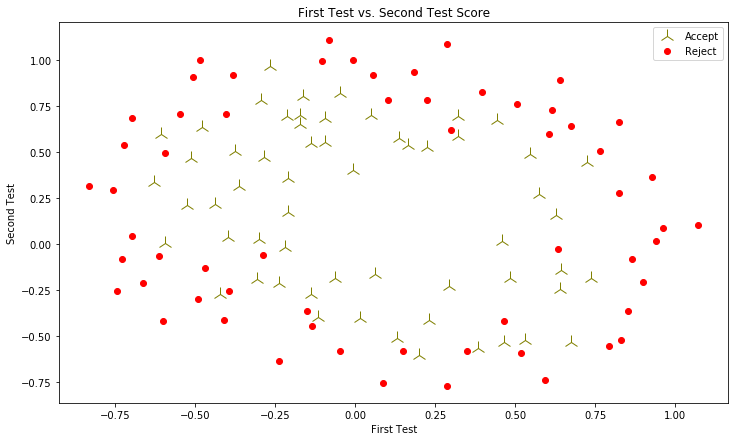

In [21]:
plt.figure(figsize= (12,7))
plt.plot(X[:,0][y == 1], X[:,1][y == 1], "2", ms=15, c= "olive")
plt.plot(X[:,0][y == 0], X[:,1][y == 0], ".", ms=12, c= "red")
plt.legend(["Accept", "Reject"])
plt.xlabel("First Test")
plt.ylabel("Second Test")
plt.title("First Test vs. Second Test Score")
plt.show()

The above figure shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight-forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

### 2.2 Feature mapping

One way to fit the data better is to create more features from each data point. In the function `map_feature`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$ \text{map_feature}(x) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix}^T $$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.
While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting. In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.


In [22]:
def map_feature(X1, X2, degree=6):
    """
    Maps the two input features to quadratic features used in the regularization exercise.

    Returns a new feature array with more features, comprising of
    X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..

    Parameters
    ----------
    X1 : array_like
        A vector of shape (m, 1), containing one feature for all examples.

    X2 : array_like
        A vector of shape (m, 1), containing a second feature for all examples.
        Inputs X1, X2 must be the same size.

    degree: int, optional
        The polynomial degree.

    Returns
    -------
    : array_like
        A matrix of of m rows, and columns depend on the degree of polynomial.
    """
    if X1.ndim > 0:
        out = [np.ones(X1.shape[0])]
    else:
        out = [np.ones(1)]
    # create features
    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((X1 ** (i - j)) * (X2 ** j))

    if X1.ndim > 0:
        # for higher degree of matrix we need vertical shape
        return np.stack(out, axis=1)
    else:
        # if we have 0 degree only array is enough (Horizontal)
        return np.array(out)

In [23]:
X = map_feature(X[:,0], X[:,1])

### 2.3 Cost function and gradient

Now you will implement code to compute the cost function and gradient for regularized logistic regression. Complete the code for the function `cost_function_gradient_descent_regularized` below to return the cost and gradient.

Recall that the regularized cost function in logistic regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that you should not regularize the parameters $\theta_0$. The gradient of the cost function is a vector where the $j^{th}$ element is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$

In [24]:
def cost_function_gradient_descent_regularized(theta, X, y, lambda_):
    """
    Compute cost and gradient for logistic regression with regularization.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept. If we have mapped
        our initial features into polynomial features, then n is the total 
        number of polynomial features. 
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    
    Instructions
    ------------
    Compute the cost `J` of a particular choice of theta.
    Compute the partial derivatives and set `grad` to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ===================== YOUR CODE HERE ======================
    h = sigmoid(X.dot(theta.T))
    
    temp = theta
    temp[0] = 0
    
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
    
    grad = (1 / m) * (h - y).dot(X) 
    grad = grad + (lambda_ / m) * temp
    
    # =============================================================
    return J, grad

In [25]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1
# DO NOT use `lambda` as a variable name in python
# because it is a python keyword
lambda_ = 1

# Compute and display initial cost and gradient for regularized logistic
# regression
cost, grad = cost_function_gradient_descent_regularized(initial_theta, X, y, lambda_)

print('Cost at initial theta (zeros): {:.3f}'.format(cost))
print('Expected cost (approx)       : 0.693\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]\n')

Cost at initial theta (zeros): 0.693
Expected cost (approx)       : 0.693

Gradient at initial theta (zeros) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]
Expected gradients (approx) - first five values only:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]



In [26]:
# Compute and display cost and gradient
# with all-ones theta and lambda = 10
test_theta = np.ones(X.shape[1])
cost, grad = cost_function_gradient_descent_regularized(test_theta, X, y, 10)

print('Cost at test theta    : {:.2f}'.format(cost))
print('Expected cost (approx): 3.16\n')

print('Gradient at initial theta (zeros) - first five values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]'.format(*grad[:5]))
print('Expected gradients (approx) - first five values only:')
print('\t[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]')

Cost at test theta    : 3.16
Expected cost (approx): 3.16

Gradient at initial theta (zeros) - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]
Expected gradients (approx) - first five values only:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]


#### 2.3.1 Learning parameters using `scipy.optimize.minimize`

Similar to the previous parts, you will use `optimize.minimize` to learn the optimal parameters $\theta$. If you have completed the cost and gradient for regularized logistic regression (`cost_function_gradient_descent_regularized`) correctly, you should be able to step through the next part of to learn the parameters $\theta$ using `optimize.minimize`.

In [39]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1 (you should vary this)
lambda_ = 1

result = optimize.minimize(cost_function_gradient_descent_regularized, initial_theta, (X, y, lambda_), jac=True, 
                           method="BFGS")

# the fun property of OptimizeResult object returns
# the value of costFunction at optimized theta
cost = result.fun

# the optimized theta is in the x property of the result
theta_optimized = result.x

# check successful of fail
print("Successful ?: {}".format(result.success))

Successful ?: True


In [40]:
# Compute accuracy on our training set
model_predicted = predict(theta_optimized, X)

print("Train Accuracy: {:.1f}".format((np.mean(model_predicted == y) * 100)))
print("Expected accuracy (with lambda = 1): 83.1 % (approx)\n")

Train Accuracy: 83.1
Expected accuracy (with lambda = 1): 83.1 % (approx)



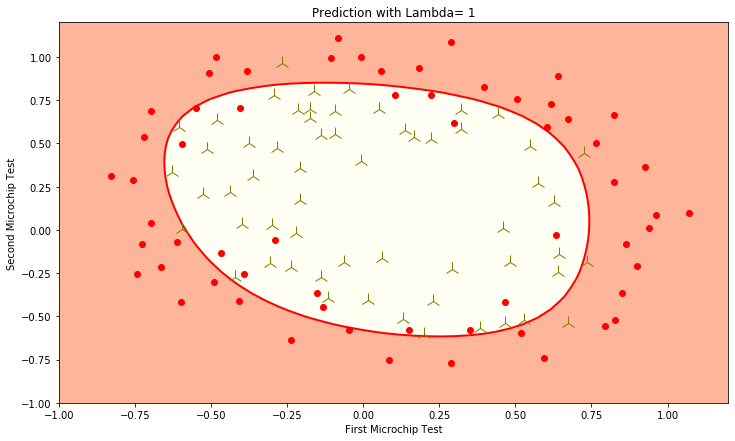

In [41]:
pos = y == 1
neg = y == 0

# Plot Examples
plt.figure(figsize= (12,7))
plt.plot(X[:,1:3][pos, 0], X[:,1:3][pos, 1], "2", ms=15, c= "olive")
plt.plot(X[:,1:3][neg, 0], X[:,1:3][neg, 1], ".", ms=12, c= "red")

u = np.linspace(-1, 1.2, 50)
v = np.linspace(-1, 1.2, 50)

z = np.zeros((u.size, v.size))
# Evaluate z = theta*x over the grid
for i, ui in enumerate(u):
    for j, vj in enumerate(v):
        z[i, j] = np.dot(map_feature(ui, vj), theta_optimized)

z = z.T  # important to transpose z before calling contour

# Plot z = 0
plt.contour(u, v, z, levels=[0], linewidths=2, colors='red')
plt.contourf(u, v, z, levels=[np.min(z), 0, np.max(z)], cmap='hot', alpha=0.4)
plt.xlabel("First Microchip Test")
plt.ylabel("Second Microchip Test")
plt.title("Prediction with Lambda= {}".format(lambda_))
plt.show()

In [42]:
# Initialize fitting parameters
initial_theta = np.zeros(X.shape[1])

# Set regularization parameter lambda to 1 (you should vary this)
lambda_ = 0

result = optimize.minimize(cost_function_gradient_descent_regularized, initial_theta, (X, y, lambda_), jac=True, 
                           method="BFGS")

# the fun property of OptimizeResult object returns
# the value of costFunction at optimized theta
cost = result.fun

# the optimized theta is in the x property of the result
theta_optimized = result.x

# check successful of fail
print("Successful ?: {}".format(result.success))

Successful ?: True


In [45]:
# Compute accuracy on our training set
model_predicted = predict(theta_optimized, X)

print("Train Accuracy: {:.1f}".format((np.mean(model_predicted == y) * 100)))
print("Expected accuracy (with lambda = 0): 91.5 % (approx)\n")

Train Accuracy: 91.5
Expected accuracy (with lambda = 0): 91.5 % (approx)



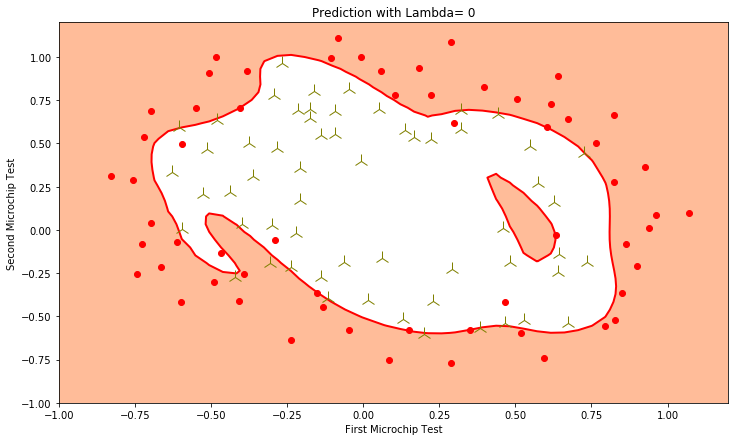

In [46]:
pos = y == 1
neg = y == 0

# Plot Examples
plt.figure(figsize= (12,7))
plt.plot(X[:,1:3][pos, 0], X[:,1:3][pos, 1], "2", ms=15, c= "olive")
plt.plot(X[:,1:3][neg, 0], X[:,1:3][neg, 1], ".", ms=12, c= "red")

u = np.linspace(-1, 1.2, 50)
v = np.linspace(-1, 1.2, 50)

z = np.zeros((u.size, v.size))
# Evaluate z = theta*x over the grid
for i, ui in enumerate(u):
    for j, vj in enumerate(v):
        z[i, j] = np.dot(map_feature(ui, vj), theta_optimized)

z = z.T  # important to transpose z before calling contour

# Plot z = 0
plt.contour(u, v, z, levels=[0], linewidths=2, colors='red')
plt.contourf(u, v, z, levels=[np.min(z), 0, np.max(z)], cmap='hot', alpha=0.4)
plt.xlabel("First Microchip Test")
plt.ylabel("Second Microchip Test")
plt.title("Prediction with Lambda= {}".format(lambda_))
plt.show()